<a href="https://colab.research.google.com/github/samuel0922/my_ex/blob/main/%5BEX_11%5DTransformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ EX_11 ] Transformer_Chatbot
### * 개요 : 한국어 데이터로 챗봇 만들기
### * 목차
* STEP 0. 환경 설정하기 
* STEP 1. 데이터 수집하기
* STEP 2. 데이터 전처리하기
* STEP 3. SubwordTextEncoder 사용하기
* STEP 4. 모델 구성하기
* STEP 5. 모델 평가하기
* 루브릭 및 회고


---
## STEP 0. 환경설정

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
## STEP 1. 데이터 수집하기

In [2]:
# 데이터 준비 : 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용

chatbot_data = pd.read_csv("/content/drive/MyDrive/aiffel/transformer_chatbot/data/ChatbotData.csv", sep=',')
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
#
# 전처리
#

# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [4]:
# 전처리 함수 : 한국어

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  sentence = sentence.strip()
  return sentence


In [5]:
# 전처리 함수 확인
preprocess_sentence(chatbot_data['Q'][1])

'1지망 학교 떨어졌어'

In [6]:
# 데이터를 전처리하여 질문을 questions, 답변을 answers에 저장
inputs, outputs = [], []
for questions, answers in zip(chatbot_data['Q'], chatbot_data['A']):
    
    inputs.append(preprocess_sentence(questions))
    outputs.append(preprocess_sentence(answers))

In [7]:
# 저장한 질문, 답변을 확인
print('전체 샘플 수 :', len(inputs))
print('전체 샘플 수 :', len(outputs))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print('전처리 후의 7번째 질문 샘플: {}'.format(inputs[7]))
print('전처리 후의 7번째 답변 샘플: {}'.format(outputs[7]))

전처리 후의 7번째 질문 샘플: sns 맞팔 왜 안하지ㅠㅠ
전처리 후의 7번째 답변 샘플: 잘 모르고 있을 수도 있어요 .


---
## STEP 3. SubwordTextEncoder 사용하기

In [9]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)


In [10]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [11]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [13]:
# 임의의 7번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 7번째 질문 샘플: {}'.format(tokenizer.encode(inputs[7])))
print('정수 인코딩 후의 7번째 답변 샘플: {}'.format(tokenizer.encode(outputs[7])))

정수 인코딩 후의 7번째 질문 샘플: [1947, 644, 1128, 7949, 66, 5113, 851]
정수 인코딩 후의 7번째 답변 샘플: [14, 1890, 29, 71, 25, 1]


In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [15]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


In [16]:
questions, answers = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


---
## STEP 4. 모델 구성하기
### STEP 4-1. 모델 구성에 필요한 함수 정의

In [17]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [18]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)  # depth는 무엇일꼬?

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


In [20]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]


In [21]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)


In [22]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [23]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [24]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [25]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


---
### STEP 4-2. TRANSFORMER 모델 구성하기

In [26]:
# TRANSFORMER
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [27]:
# HYPER PARAMETER Tuning

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3147008     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [28]:
# TEACHER FORCING

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [41]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0151 - accuracy: 0.1713
Epoch 2/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0143 - accuracy: 0.1715
Epoch 3/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0133 - accuracy: 0.1718
Epoch 4/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0120 - accuracy: 0.1721
Epoch 5/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0119 - accuracy: 0.1722
Epoch 6/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0104 - accuracy: 0.1725
Epoch 7/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0101 - accuracy: 0.1726
Epoch 8/50
185/185 [==============================] - 10s 54ms/step - loss: 0.0098 - accuracy: 0.1727
Epoch 9/50
185/185 [==============================] - 10s 55ms/step - loss: 0.0091 - accuracy: 0.1729
Epoch 10/50
185/185 [==============================] - 10s 55ms/step - loss: 0.008

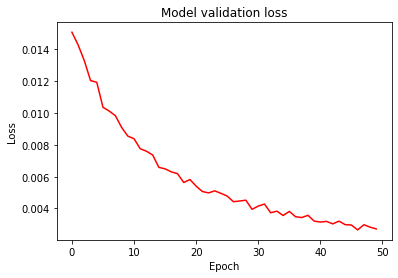

In [42]:
plt.plot(history.history['loss'], 'r')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

---
## STEP 5. 모델 평가하기

In [43]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)


In [44]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


In [45]:
sentence_generation('너 어디 갔었어?')

입력 : 너 어디 갔었어?
출력 : 가게부를 써보세요 .


'가게부를 써보세요 .'

In [46]:
sentence_generation("오늘 날씨가 좋을것 같아?")

입력 : 오늘 날씨가 좋을것 같아?
출력 : 좋은 사람이 찾아오려나봐요 .


'좋은 사람이 찾아오려나봐요 .'

In [47]:
sentence_generation("어디로 놀러 가면 좋을까?")


입력 : 어디로 놀러 가면 좋을까?
출력 : 안 가본 가까운 곳이 좋겠죠 .


'안 가본 가까운 곳이 좋겠죠 .'

In [48]:
sentence_generation("하고 싶은 말이 뭐야?")

입력 : 하고 싶은 말이 뭐야?
출력 : 하면서 좋거나 재밌거나 잘하는게 있었는지 깊게 고민해보세요 .


'하면서 좋거나 재밌거나 잘하는게 있었는지 깊게 고민해보세요 .'

In [49]:
sentence_generation("언제 만나러 갈까?")

입력 : 언제 만나러 갈까?
출력 : 잘하고 오세요 .


'잘하고 오세요 .'

---
## [ 루브릭 ]

#### 1. 한국어 전처리를 통해 학습 데이터셋 구축
* 전처리, 토크나이징, 병렬데이터 구축 과정 진행 하였음

#### 2. 트랜스포머 모델 구현 -> 한국어 챗봇 모델 학습 정상적 진행
* 구현한 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였음

#### 3. 한국어 입력문장에 대해 한국어로 답변하는 함수 구현
* 한국어 입력문장에 비교적 그럴듯한 한국어로 답변 리턴하였음????? => 요건 의문

##### > Try 1. 하이퍼파라미터를 초기 설정으로 두고 EPOCH만 늘려가면서 결과를 확인해 봄
* NUM_LAYERS = 8 # 인코더와 디코더의 층의 개수
* D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
* NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
* UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
* DROPOUT = 0.1 # 드롭아웃의 비율

>>EPOCH     30 이후 질문&답변 - loss: 0.4142 - accuracy: 0.0946
* 어디 갔었어.....................? 더 많이 연락하고 관심 가져주세요.    
* 오늘 날씨가 졸을것 같아?          더 많이 연락하고 관심 가져주세요.   
* 어디로 놀러가면 좋을까.?          이제 일어날 시간이예요.
* 하고 싶은 말이 뭐야........?      먼저 다가가 보세요.
* 언제 만나러 갈까............?     조심하세요.

>> EPOCH 추가50 이후 질문&답변 - loss: 0.2212 - accuracy: 0.1327
* 어디 갔었어.....................? 저도 보고 싶어요.
* 오늘 날씨가 졸을것 같아?          저도 보고싶어요.
* 어디로 놀러가면 좋을까.?          지금도 충분해요.
* 하고 싶은 말이 뭐야........?      자연스러운 현상이예요.
* 언제 만나러 갈까............?     회사와 자신에 대해서 더 공부해서 자신감을 가져보세요.

>> EPOCH 추가50 이후 질문&답변 - loss: 0.1968 - accuracy: 0.1376
* 어디 갔었어.....................? 많이 당황했겠어요?.
* 오늘 날씨가 졸을것 같아?          더 좋은 기회가 올거예요.
* 어디로 놀러가면 좋을까.?          맞아요. 예뻐요.
* 하고 싶은 말이 뭐야........?      서로 속도를 맞춰보세요.
* 언제 만나러 갈까............?     축하드려요.

##### > Try 2. 하이퍼파라미터 중 NUM_HEADS를 8->16으로 변경하고 EPOCH 50만 시도
* NUM_LAYERS = 8 # 인코더와 디코더의 층의 개수
* D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
* NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
* UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
* DROPOUT = 0.1 # 드롭아웃의 비율

>> EPOCH     50 이후 질문&답변 - loss: 0.2453 - accuracy: 0.1279
* 어디 갔었어.....................? 다른 생각을 해 보세요.    
* 오늘 날씨가 졸을것 같아?          제가 들어드릴께요.   
* 어디로 놀러가면 좋을까.?          직접 물어보는게 좋을것 같아요.
* 하고 싶은 말이 뭐야........?      정말 사랑하는 사람을 만나면 다를거예요.
* 언제 만나러 갈까............?     축하드려요.

##### > Try 3. NUM_LAYERS=2, NUM_HEADS를 8로 변경하고 EPOCH 30만 시도
* NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
* D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
* NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
* UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
* DROPOUT = 0.1 # 드롭아웃의 비율

>> EPOCH     30 이후 질문&답변 - loss: 0.0170 - accuracy: 0.1709
* 어디 갔었어.....................? 이별은 시간활용에 따라 다르겠죠.    
* 오늘 날씨가 졸을것 같아?          좋은 거일수도 있어요.   
* 어디로 놀러가면 좋을까.?          공원이나 익숙한 곳을 가 보세요.
* 하고 싶은 말이 뭐야........?      하면서 좋거나 재밌거나 잘하는게 있었는지 깊게 고민해보세요.
* 언제 만나러 갈까............?     마음을 손이 따라와주지 않죠.

>> EPOCH  추가50 이후 질문&답변 - loss: 0.0027 - accuracy: 0.1744
* 어디 갔었어.....................? 가게부를 써보세요.    
* 오늘 날씨가 졸을것 같아?          좋은 사람이 찾아오려나봐요.   
* 어디로 놀러가면 좋을까.?          안 가본 가까운 곳이 좋겠죠.
* 하고 싶은 말이 뭐야........?      하면서 좋거나 재밌거나 잘하는게 있었는지 깊게 고민해보세요.
* 언제 만나러 갈까............?     잘하고 오세요.

---
## [ 회고 ]

* 노드에서 학습한 내용을 활용해 한국어 데이터에 대한 챗봇 모델을 구성하고 학습을 시켜봄.

* 모델 구현을 통해 트랜스포머 모델에 대한 이해를 높일 수 있었음.

* 하이퍼 파라미터를 변경하며 모델에 대한 평가를 시행해 봤는데, <br>
초기 설정을 유지한 채로 Epoch값의 증가에 따라 정확도는 0.17까지 상승했는데<br> 
모델이 만들어 내는 답변의 정확도는 크게 높아진다고 보기 어려웠고<br>

* 하이퍼 파라미터 중 NUM_LAYERS나 NUM_HEADS를 증가시킨 것의 영향도 크지 않음<br>

* 다만, 오히려 NUM_LAYERS를 8->2로 낮추었을 때는 짧은 EPOCH에도 앞선 설정보다 <br> 
빨리 정확도가 향상되면서 답변의 내용중 일부 질문에 대해서는 조금은 합리적인<br> 
것을 만들어 내었다. 단, 추가적인 훈련은 유의미한 향상을 이끌어내지 못함<br>

* NUM_LAYERS를 깊게 쌓는다고 해서 모델의 답변을 만들어내는 정확성이<br> 
향상되는 것은 아닌듯함.
 




